# Double Deep Q Network (DQN) for Super Mario Bros


## Imports


In [1]:
import collections
import os
import tempfile
import time
import warnings

import gym
import gym_super_mario_bros
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
from gym_super_mario_bros.actions import COMPLEX_MOVEMENT
from nes_py.wrappers import JoypadSpace
from torch.optim import Adam
from tqdm import tqdm

from src.DQN import DQN
from src.ReplayBuffer import ReplayBuffer
from src.utils import preprocess_frame, preprocess_state, create_plots

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

os.environ["KMP_DUPLICATE_LIB_OK"] = "True"
warnings.simplefilter("ignore")
print(device)

cuda


## Environment


In [2]:
ENV_NAME = "SuperMarioBros-1-1-v0"
env = gym_super_mario_bros.make(ENV_NAME)
env = JoypadSpace(env, COMPLEX_MOVEMENT)

In [3]:
print("Observation Space: ", env.observation_space.shape)
print("Action Space: ", env.action_space.n)
print(COMPLEX_MOVEMENT)

Observation Space:  (240, 256, 3)
Action Space:  12
[['NOOP'], ['right'], ['right', 'A'], ['right', 'B'], ['right', 'A', 'B'], ['A'], ['left'], ['left', 'A'], ['left', 'B'], ['left', 'A', 'B'], ['down'], ['up']]


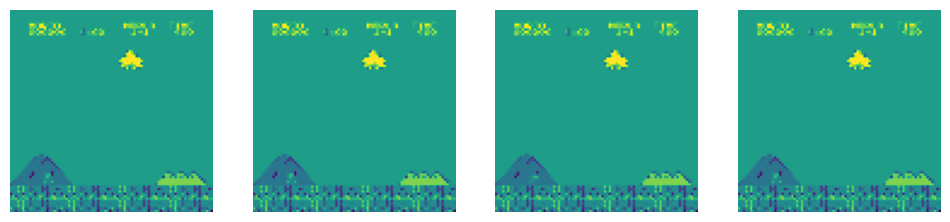

In [4]:
state = env.reset()

fig, axes = plt.subplots(1, 4, figsize=(12, 3))
axes = axes.flatten()
for i in range(4):
    state, reward, done, info = env.step(env.action_space.sample())
    state = preprocess_frame(state)

    axes[i].imshow(state)
    axes[i].axis("off")

## Train Agent


### Set Hyperparameters


In [2]:
ENV_NAME = "SuperMarioBros-1-1-v0"
GAMMA = 0.99
N_EPISODES = 100
EPSILON_START = 1.0
EPSILON_END = 0.1
# uncomment the following line to use exponential decay
# EPSILON_DECAY = 0.995
# uncomment the following line to use linear decay
EPSILON_DECAY = (EPSILON_START - EPSILON_END) / N_EPISODES

LEARNING_RATE = 1e-4
REPLAY_BUFFER = 10000
BATCH_SIZE = 64
TARGET_UPDATE = 10
N_STACKD_FRAMES = 4
INPUT_SHAPE = (4, 84, 84)

### Create Instances


In [6]:
env = gym_super_mario_bros.make(ENV_NAME)
env = JoypadSpace(env, COMPLEX_MOVEMENT)

policy_net = DQN(INPUT_SHAPE, env.action_space.n).to(device)
target_net = DQN(INPUT_SHAPE, env.action_space.n).to(device)
target_net.load_state_dict(policy_net.state_dict())

optimizer = Adam(policy_net.parameters(), lr=LEARNING_RATE)
replay_buffer = ReplayBuffer(REPLAY_BUFFER)

Experience = collections.namedtuple(
    "Experience", field_names=["state", "action", "reward", "done", "new_state"]
)

### Train Agent


Training: 100%|██████████| 100/100 [1:48:40<00:00, 65.20s/it] 


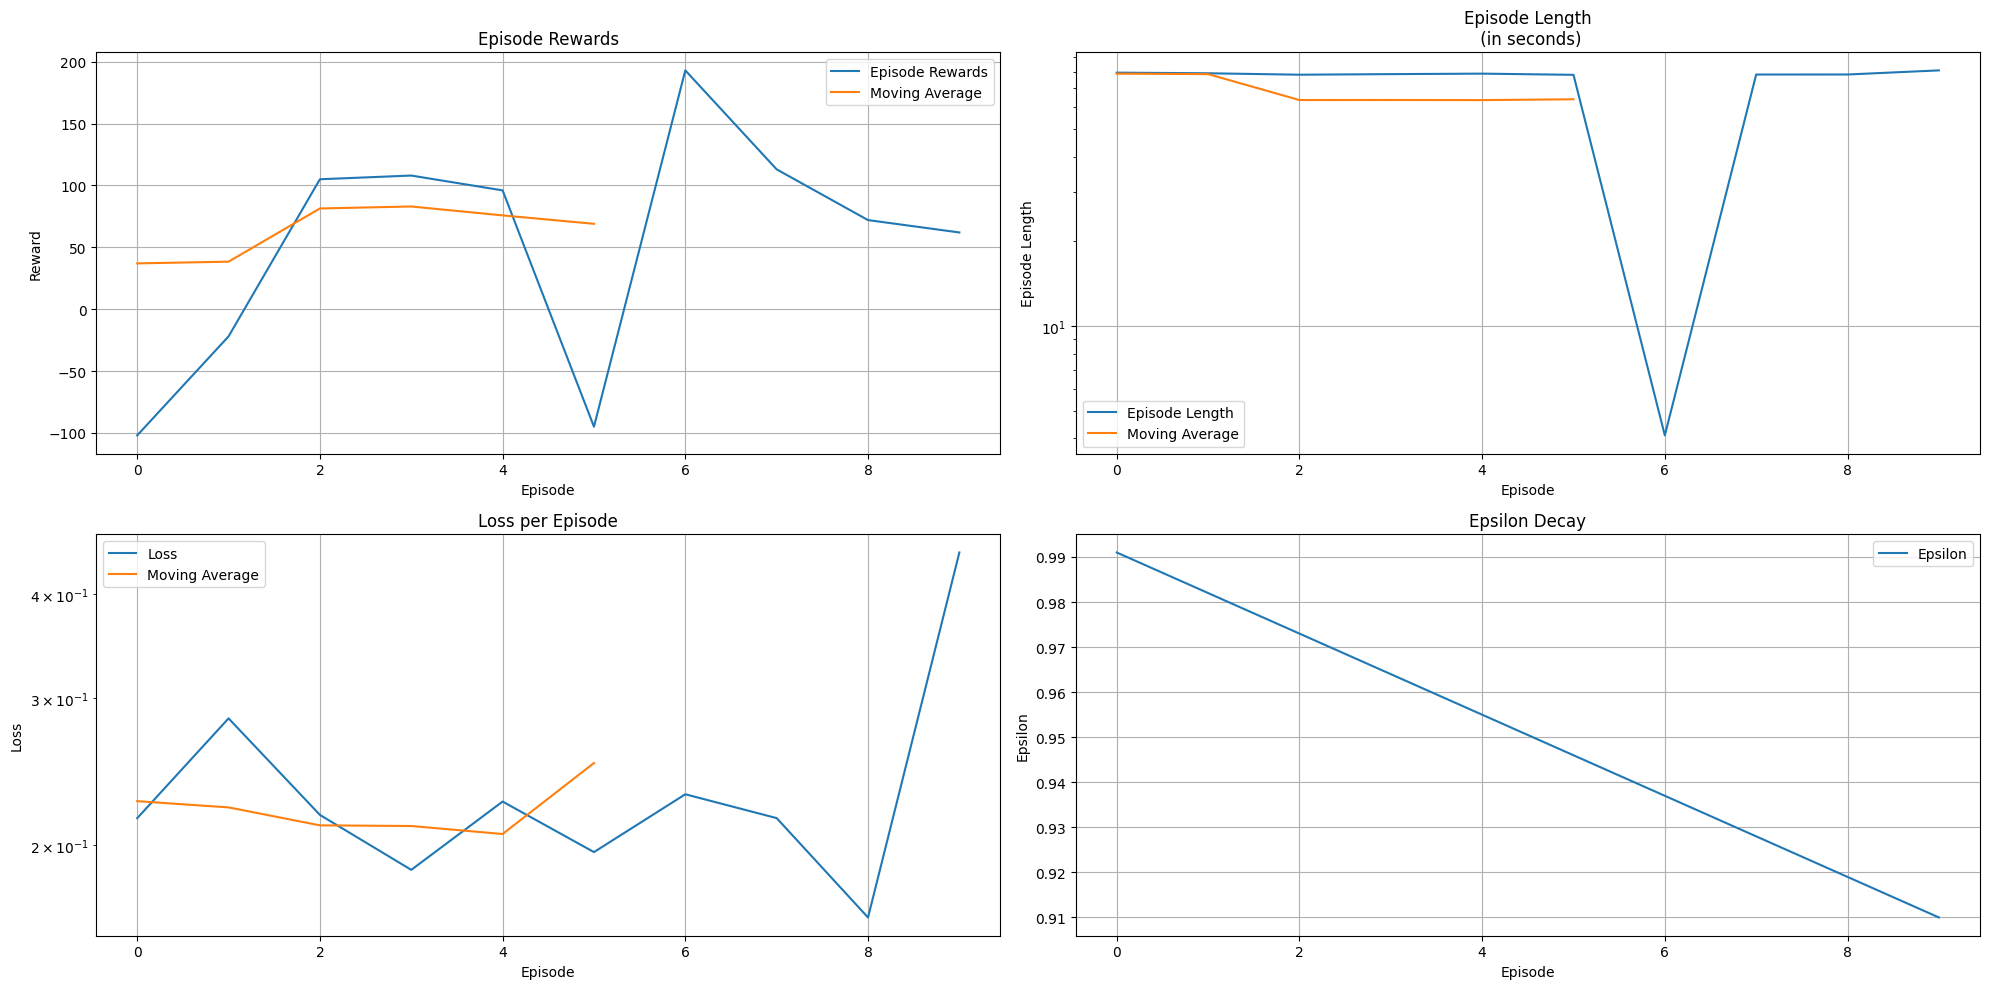

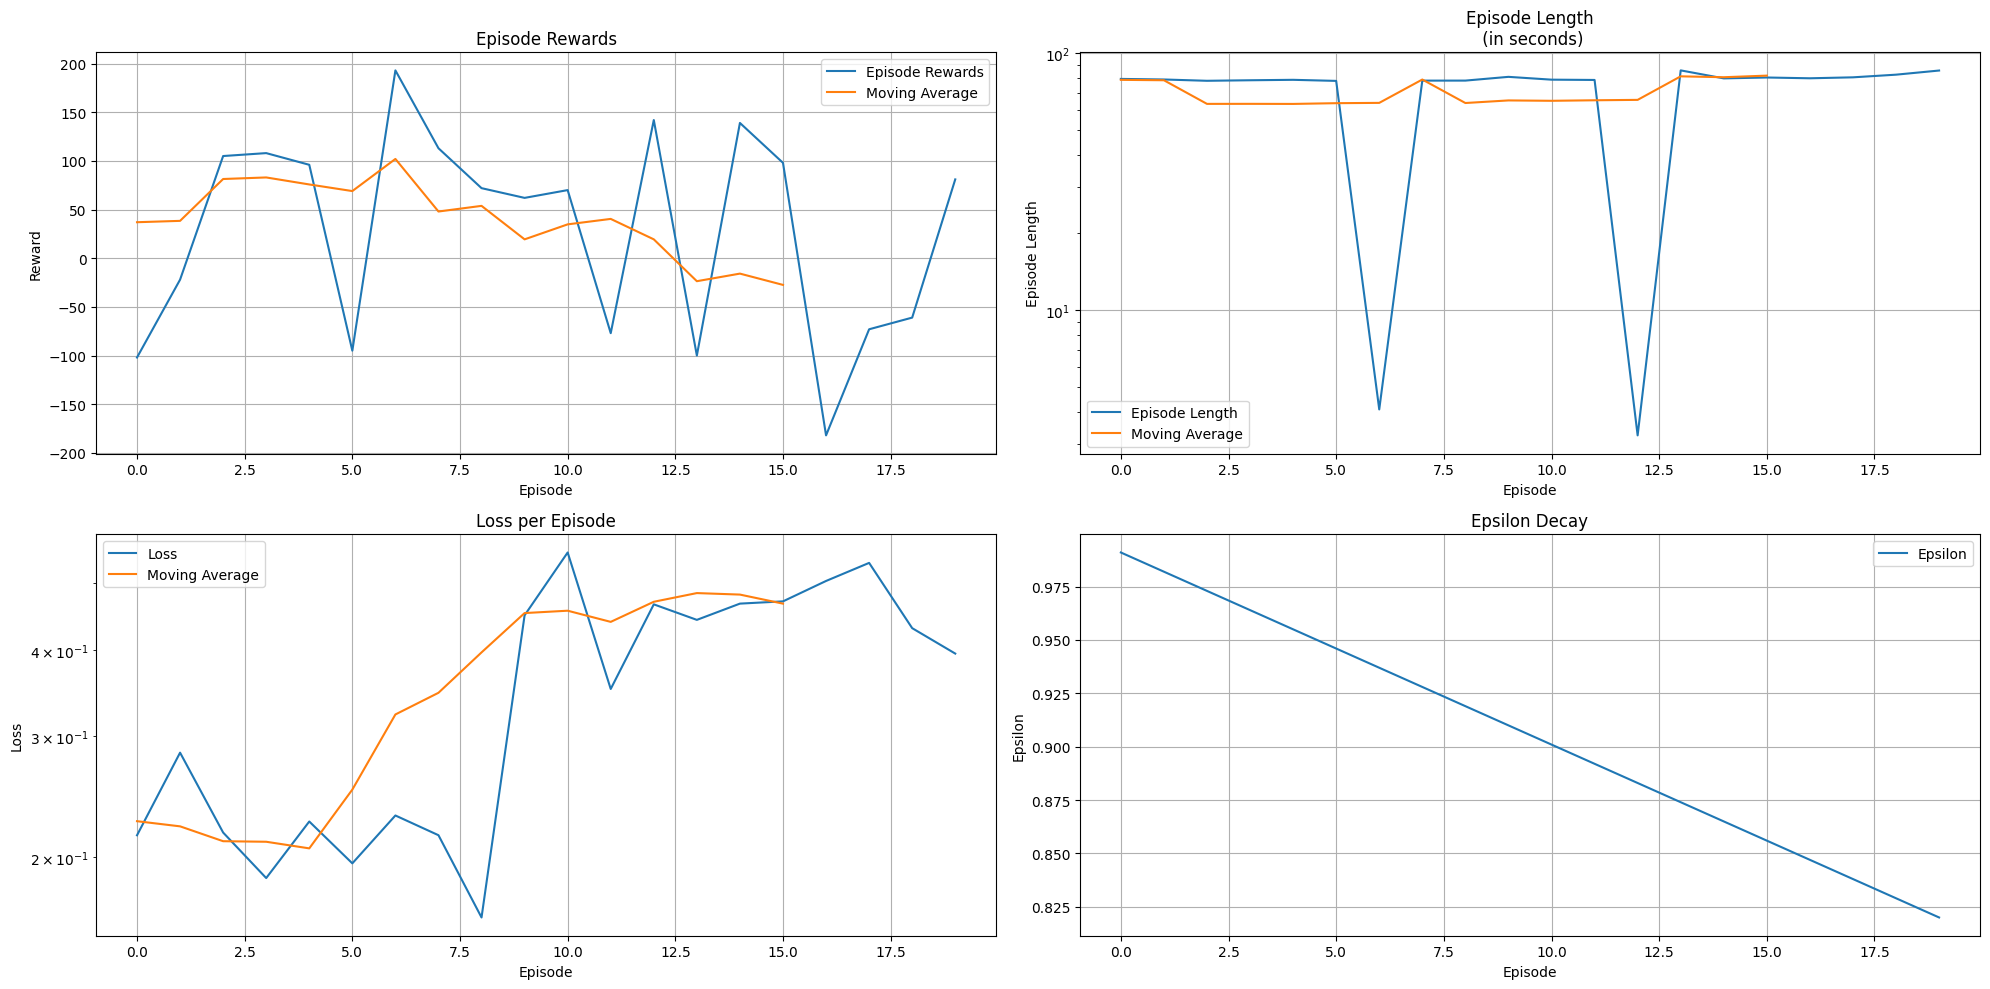

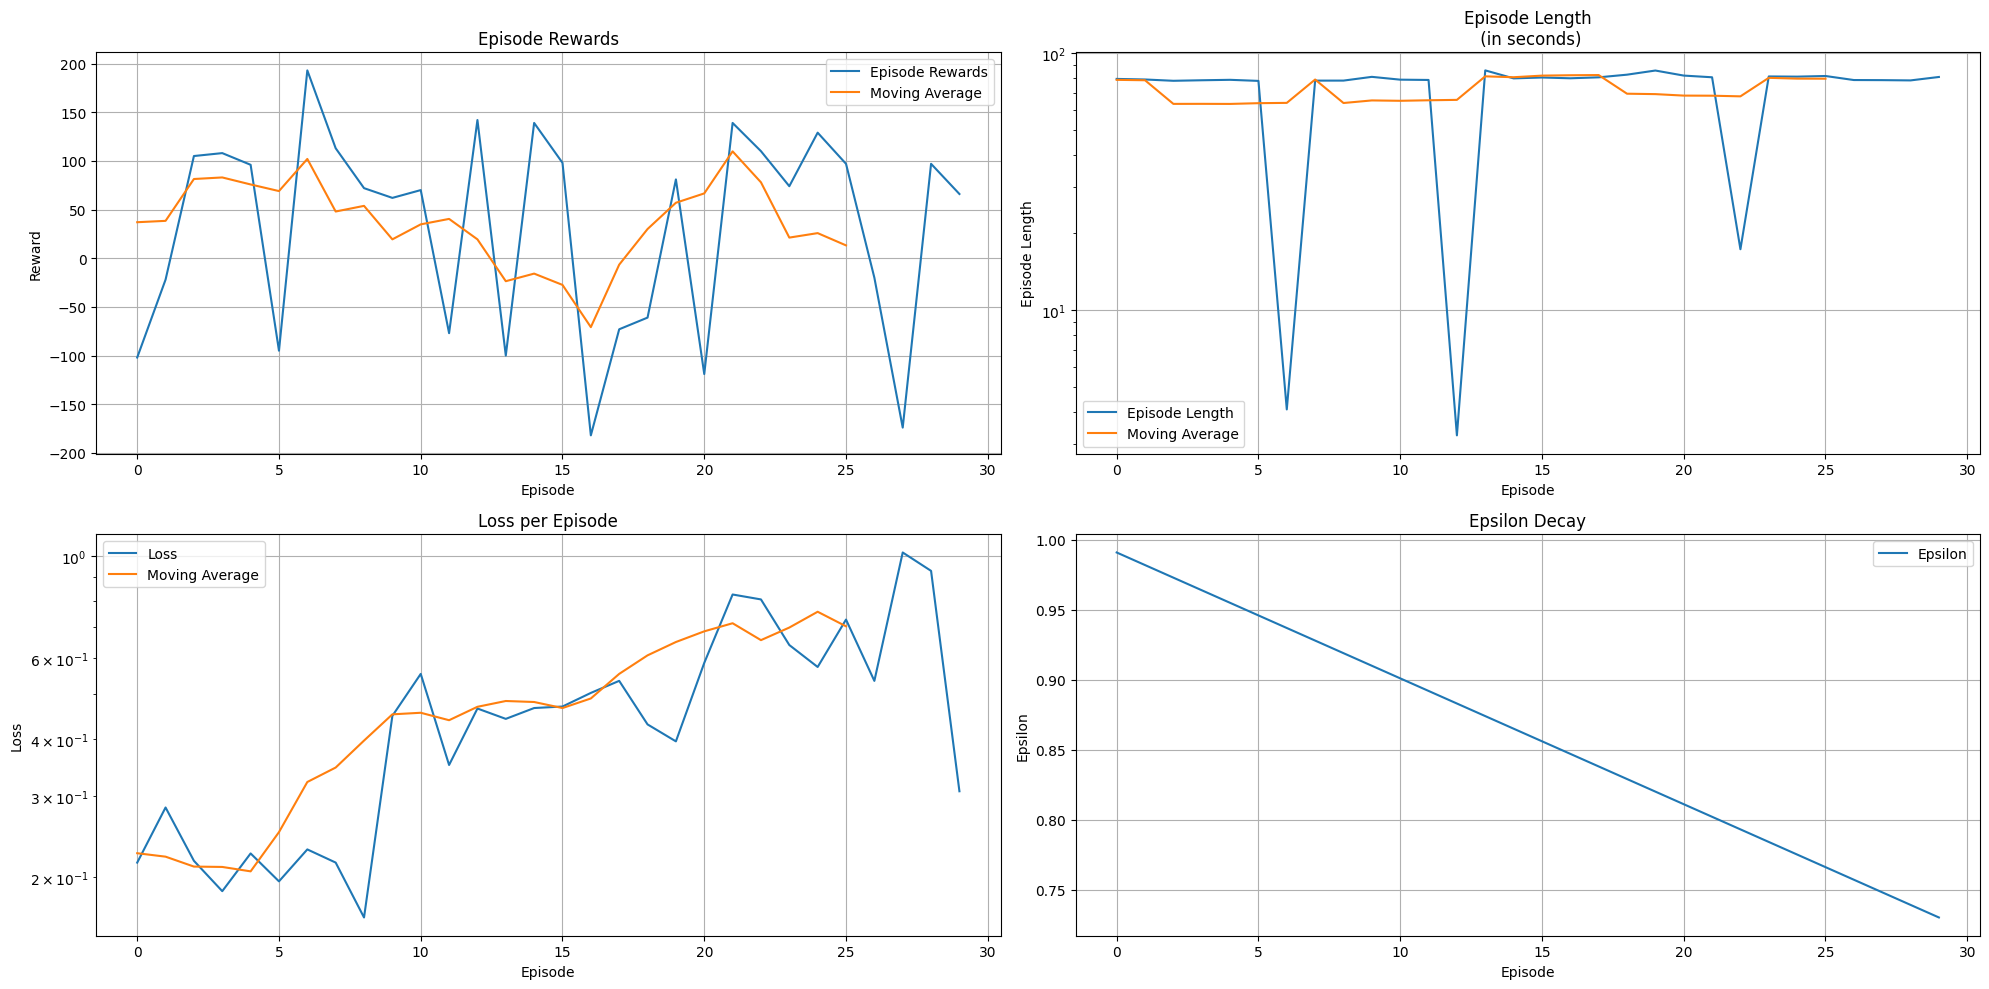

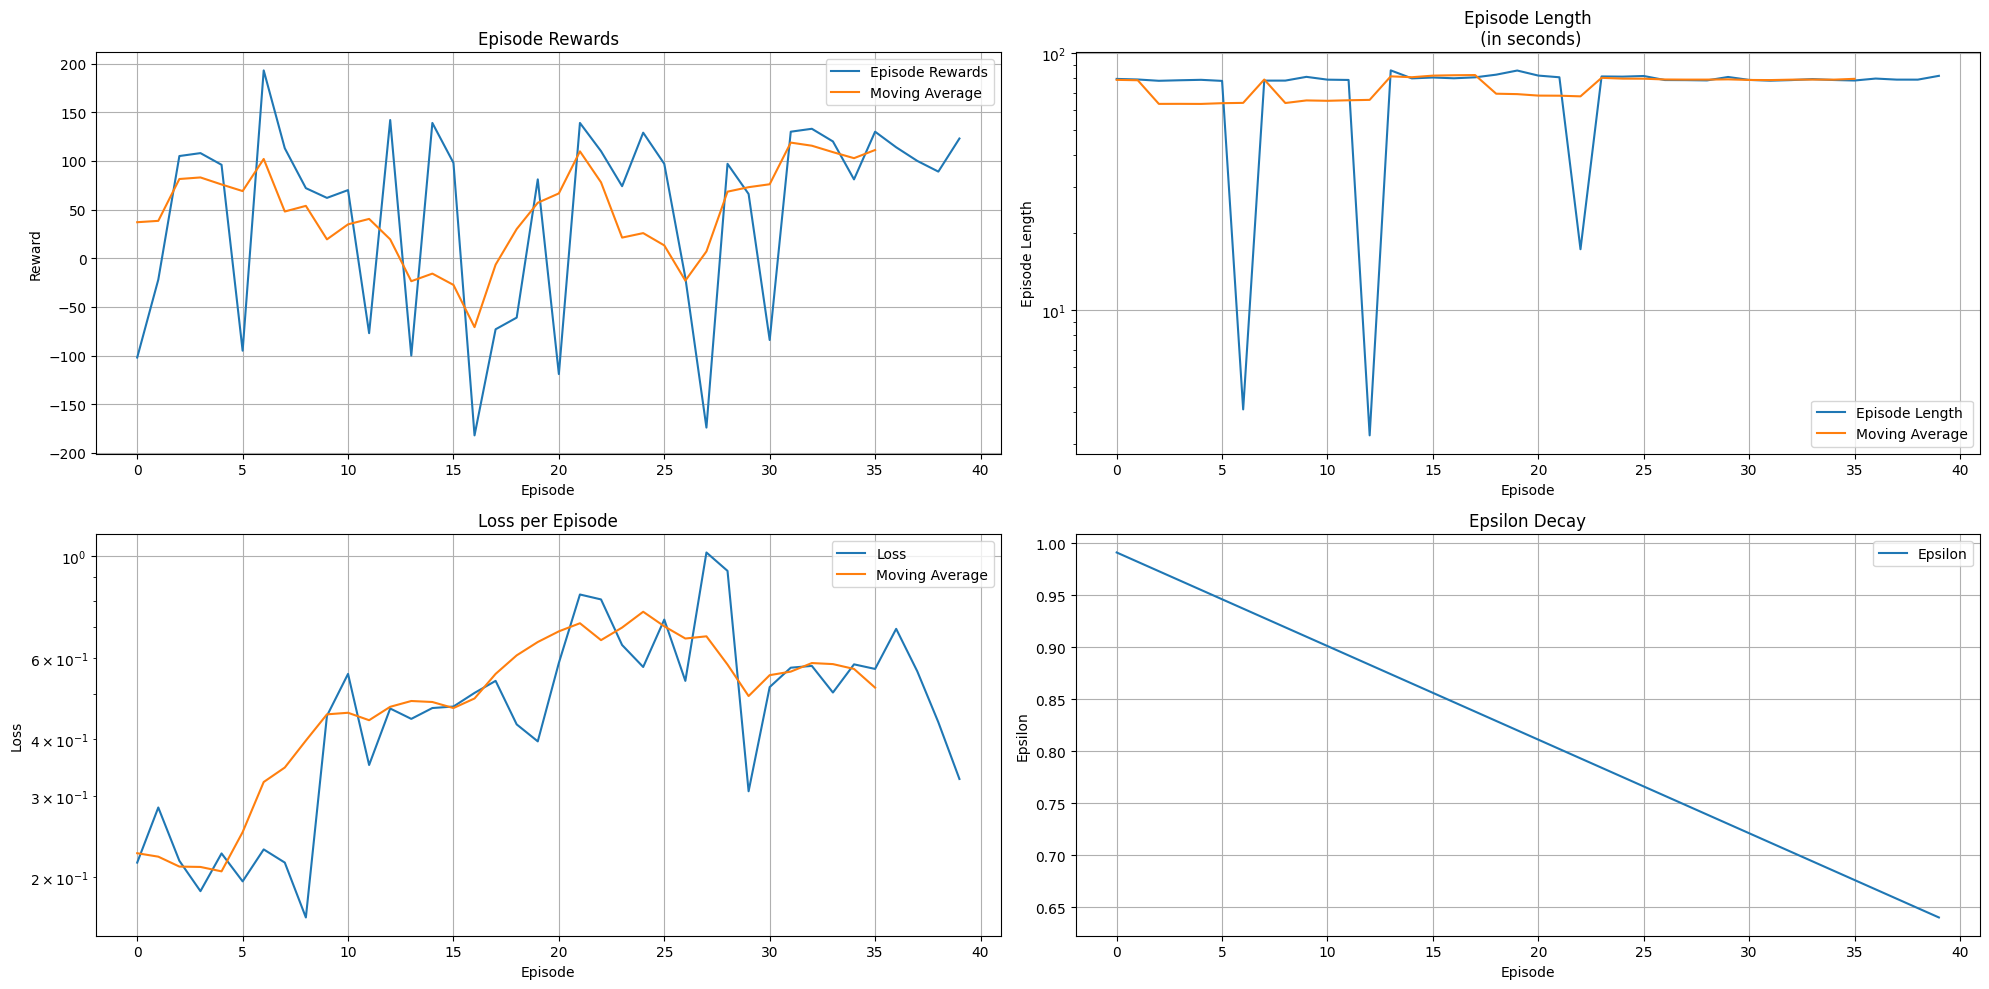

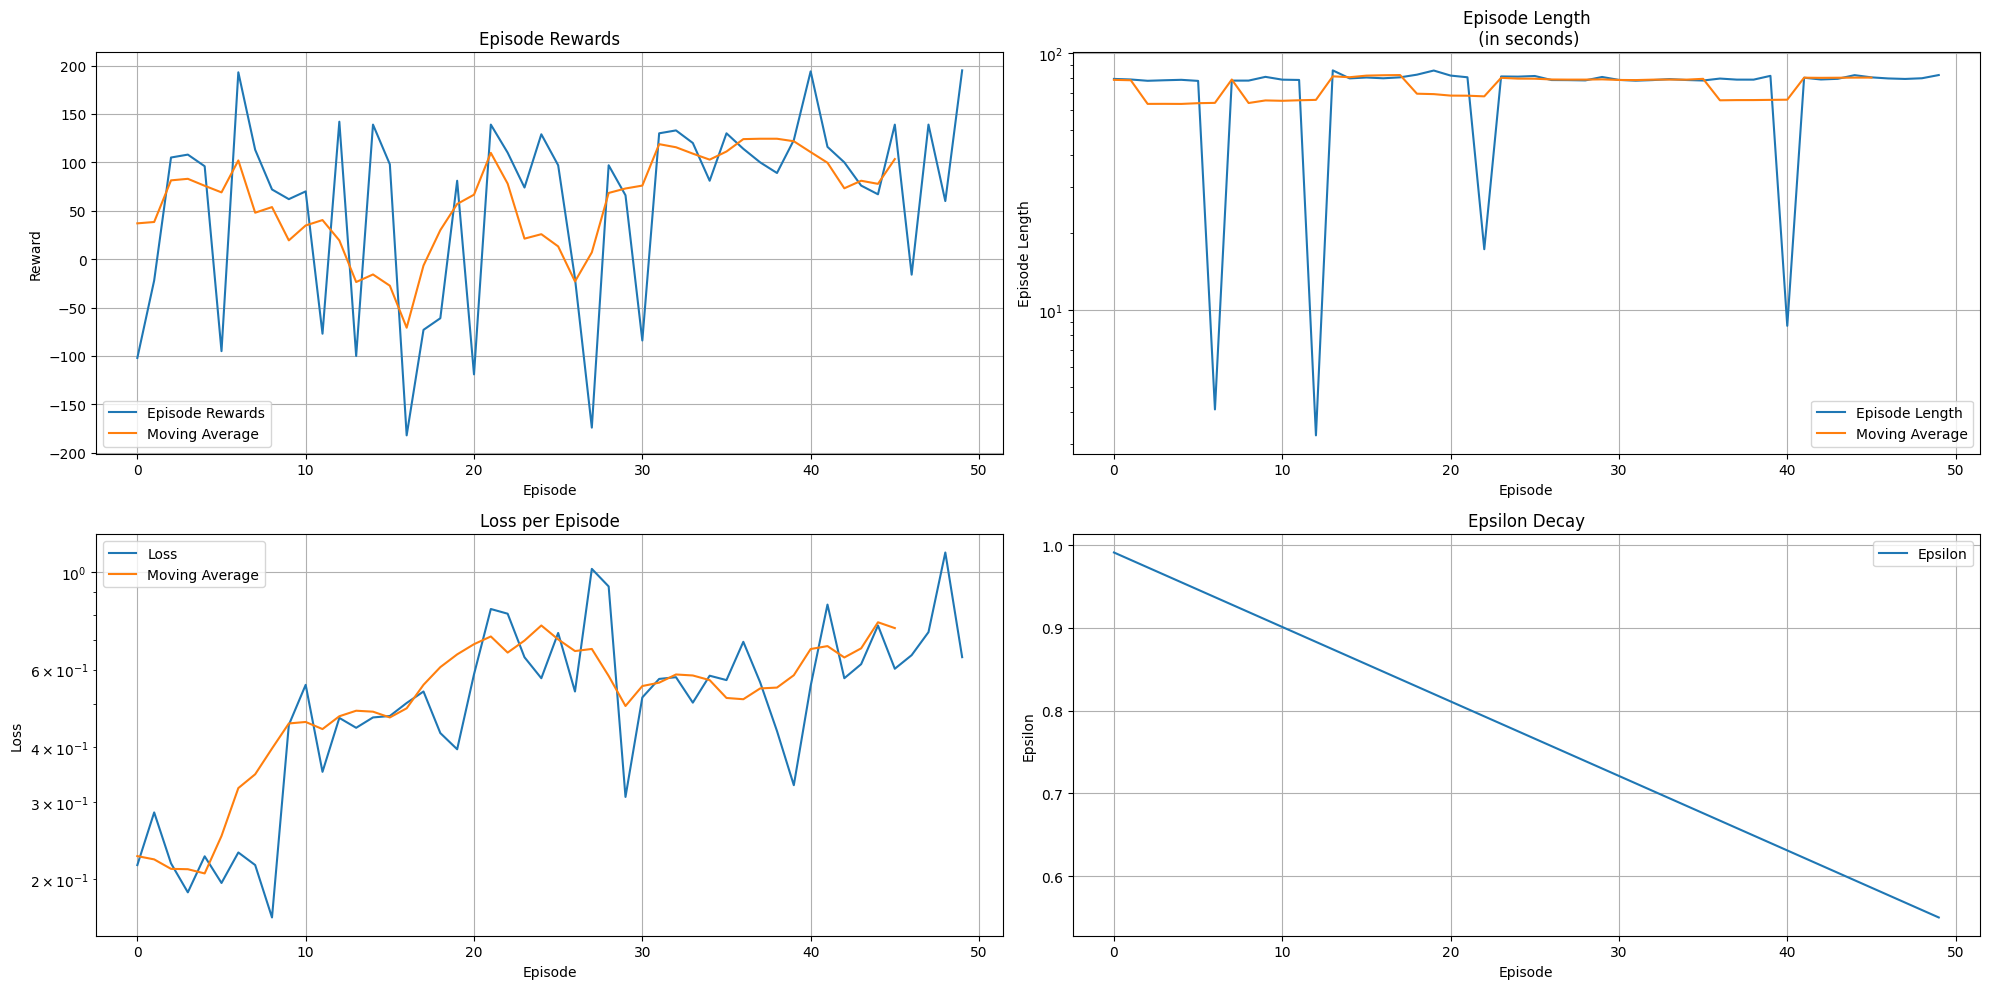

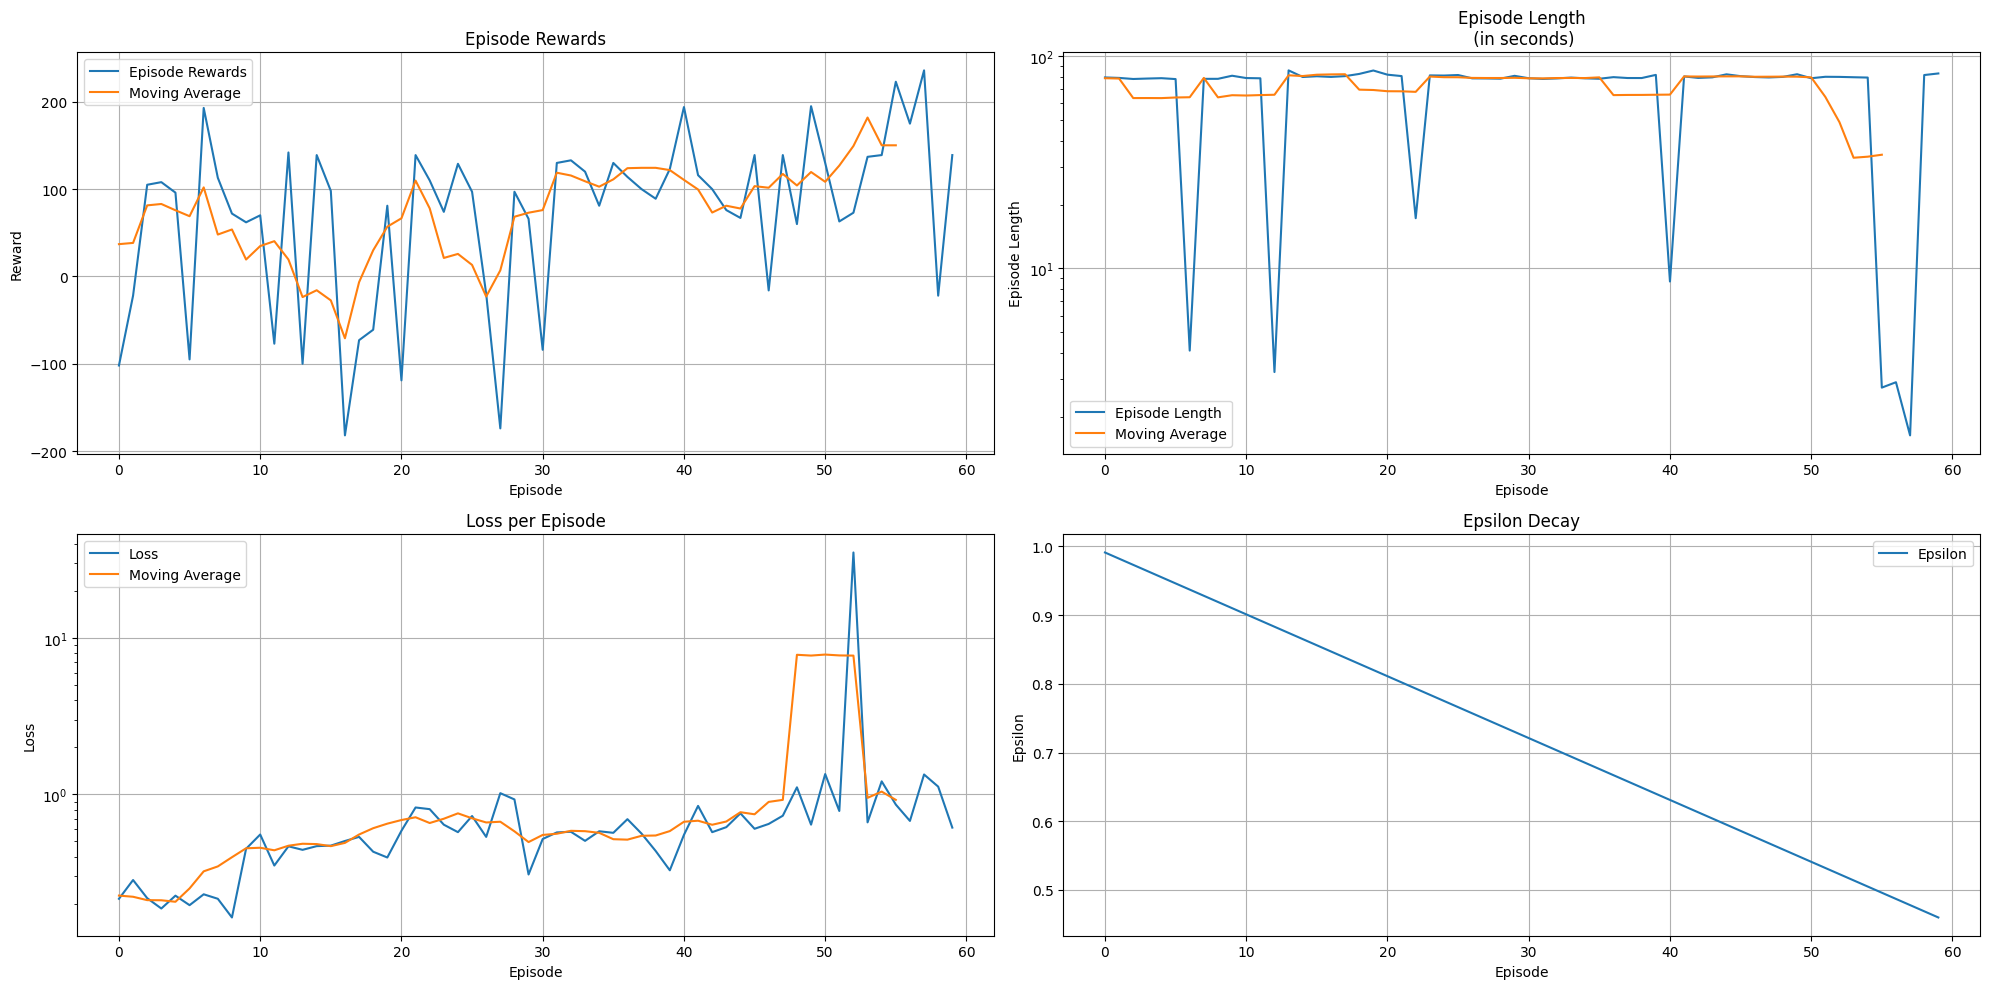

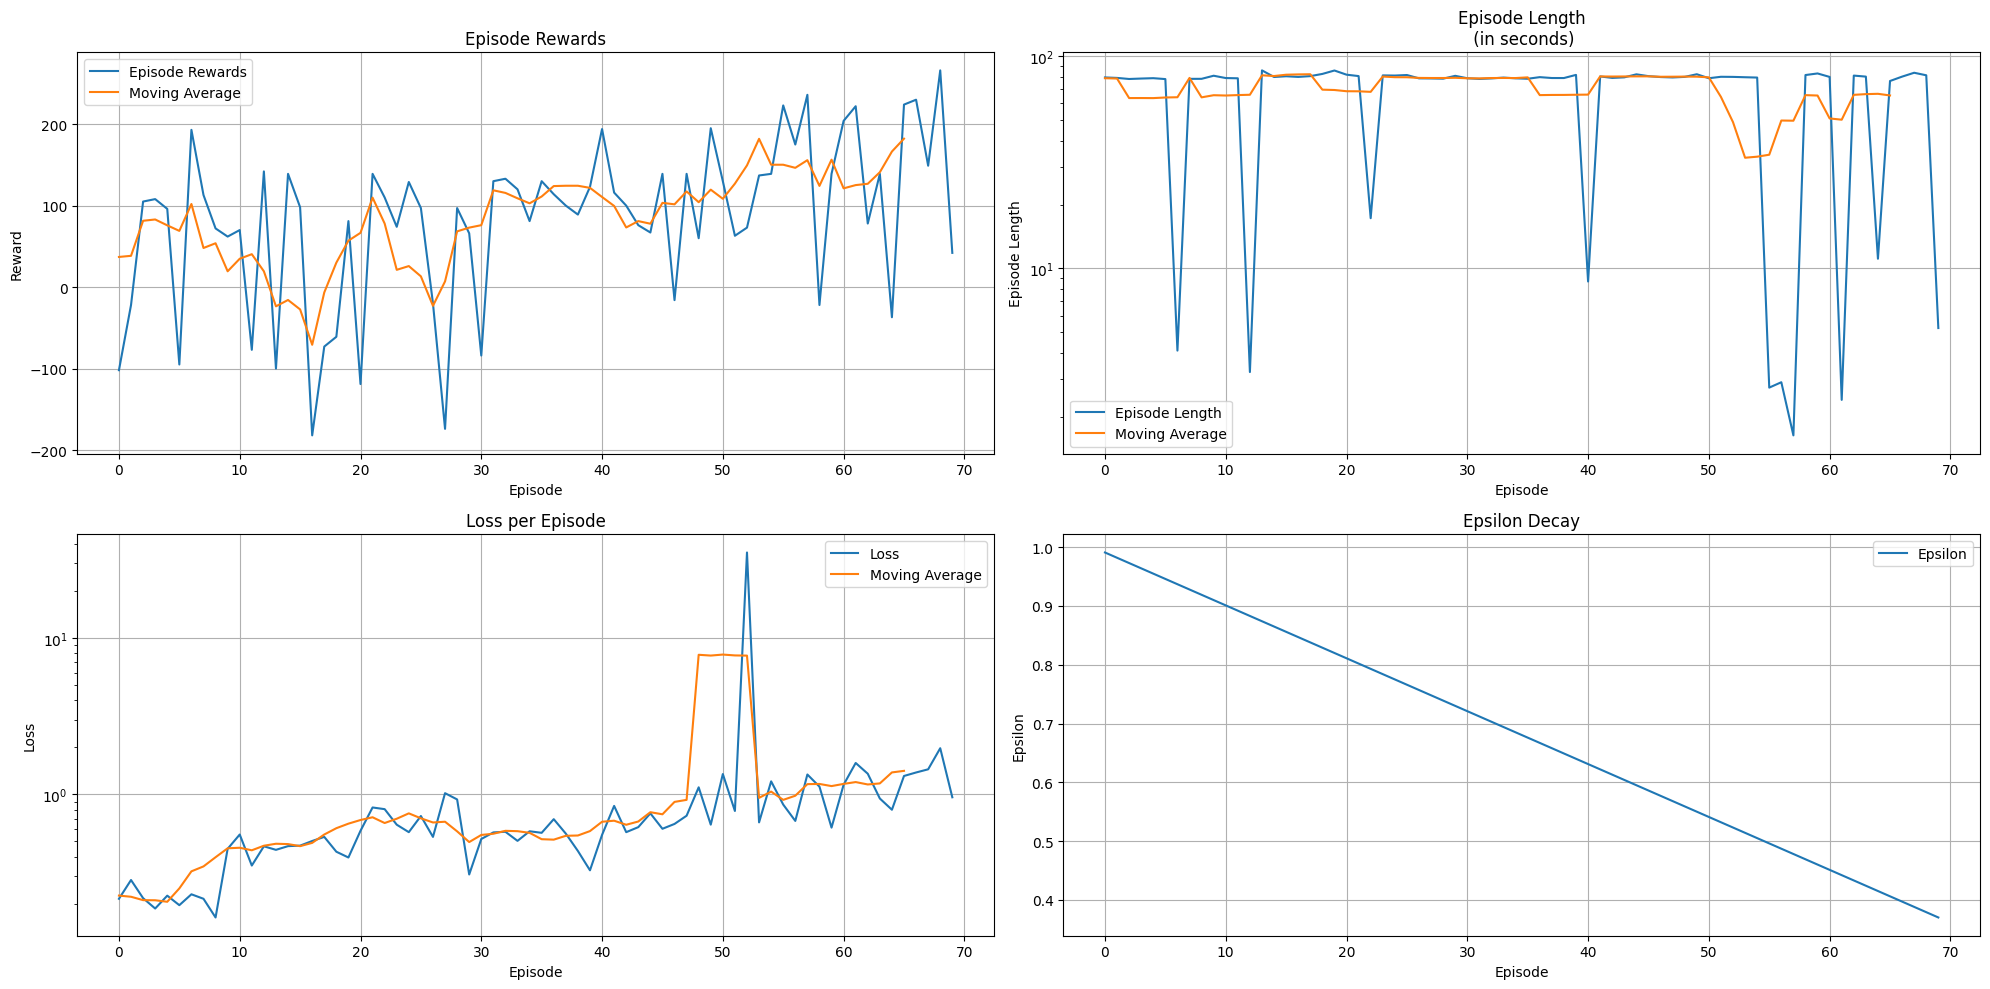

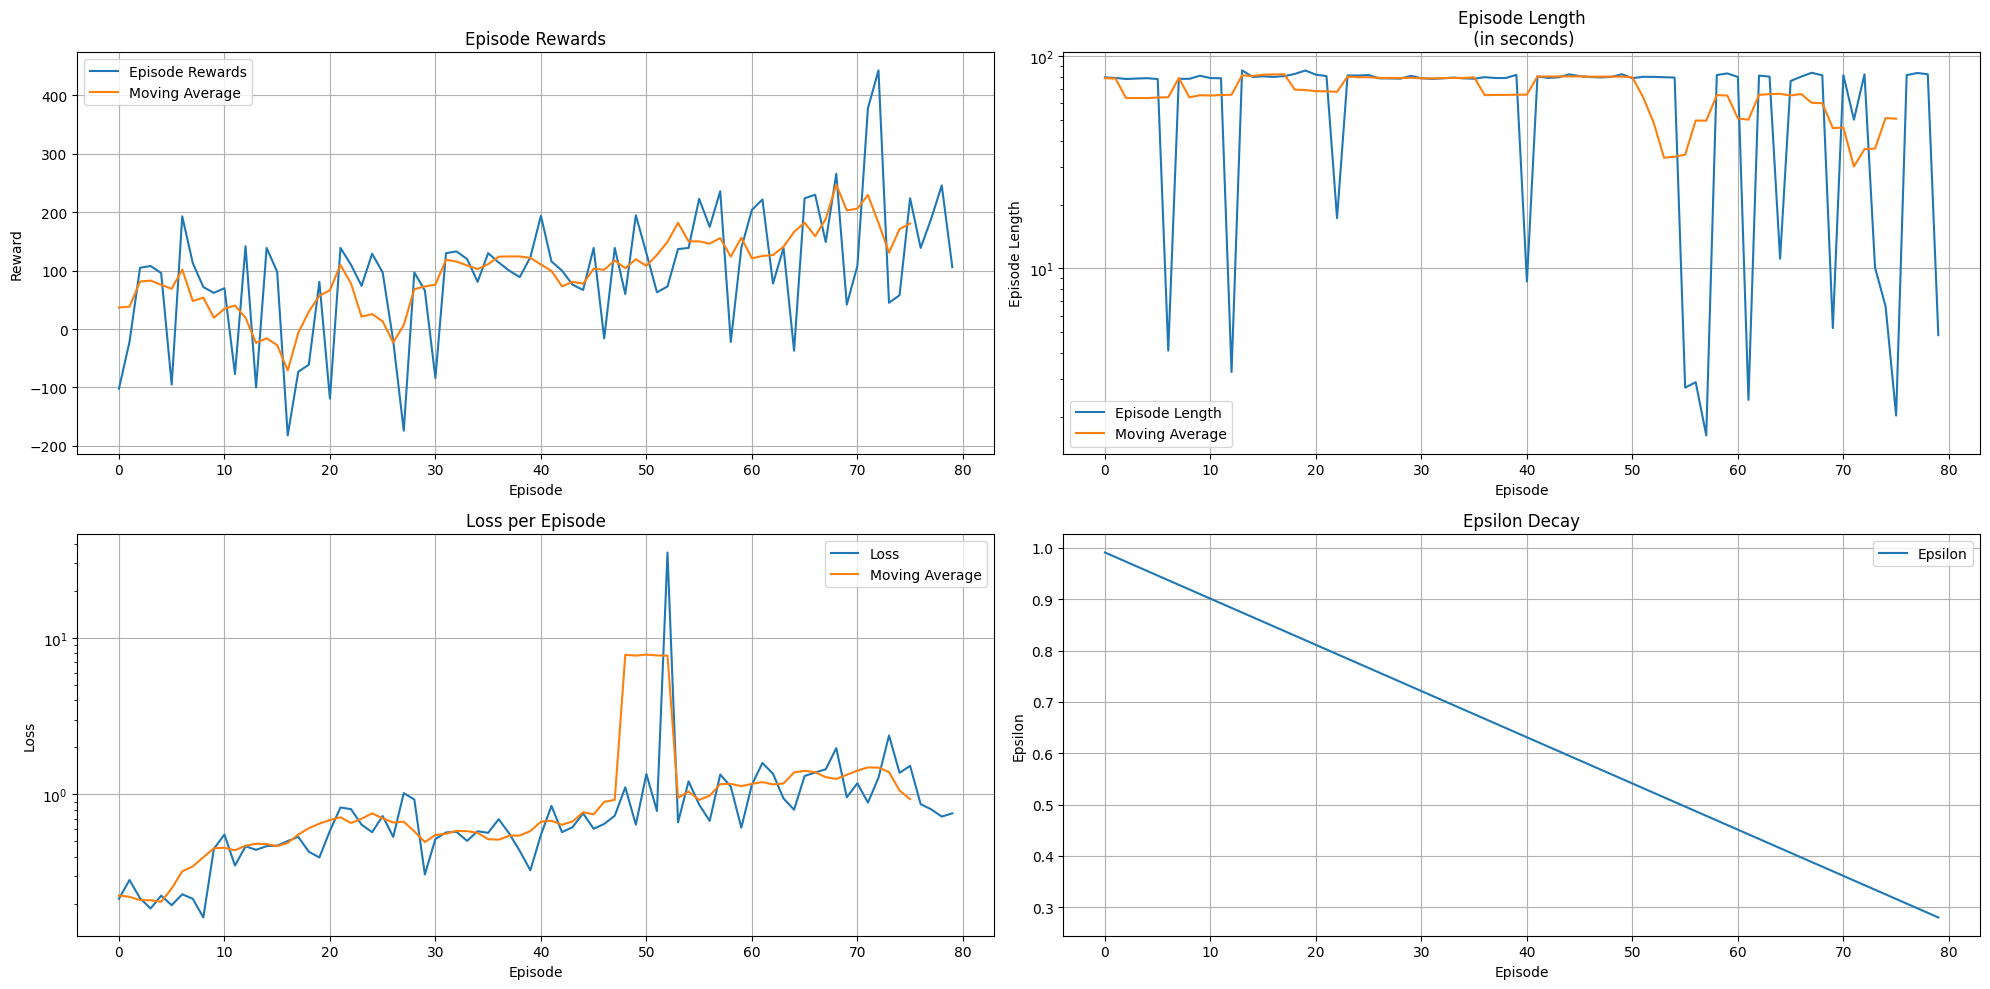

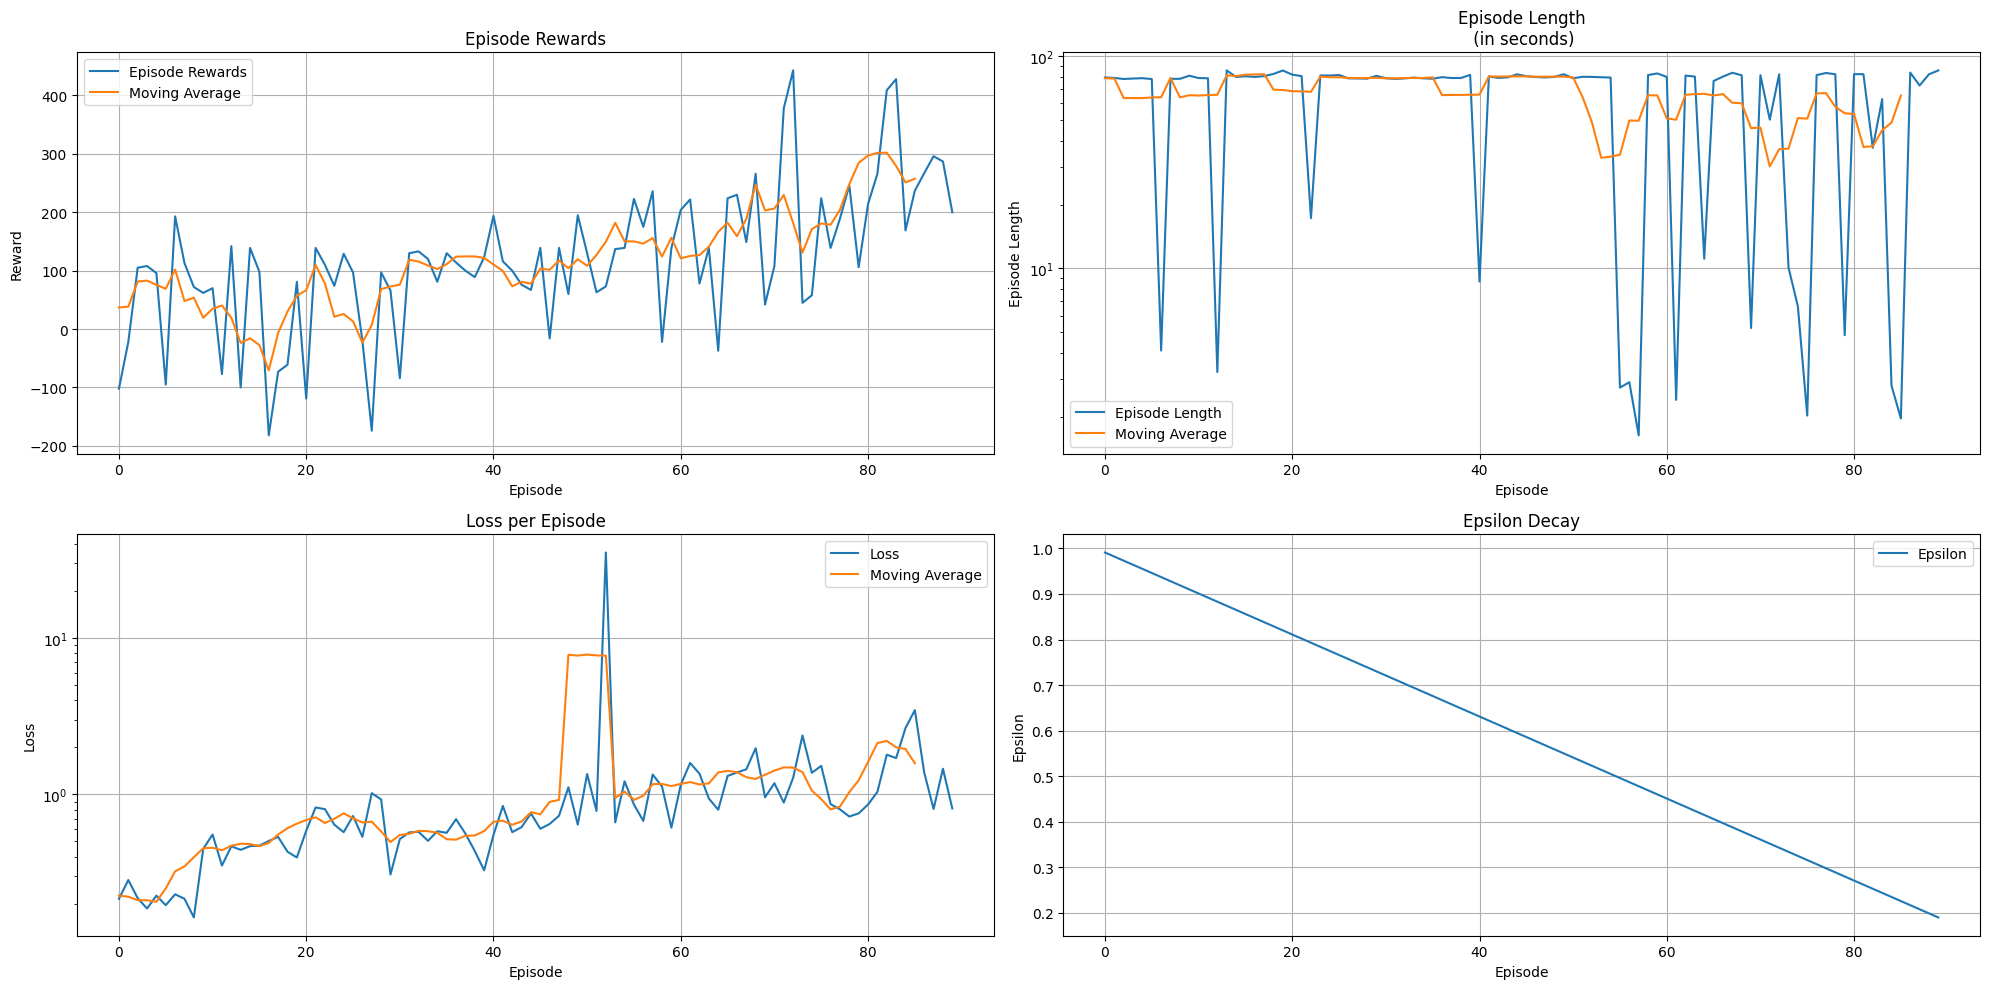

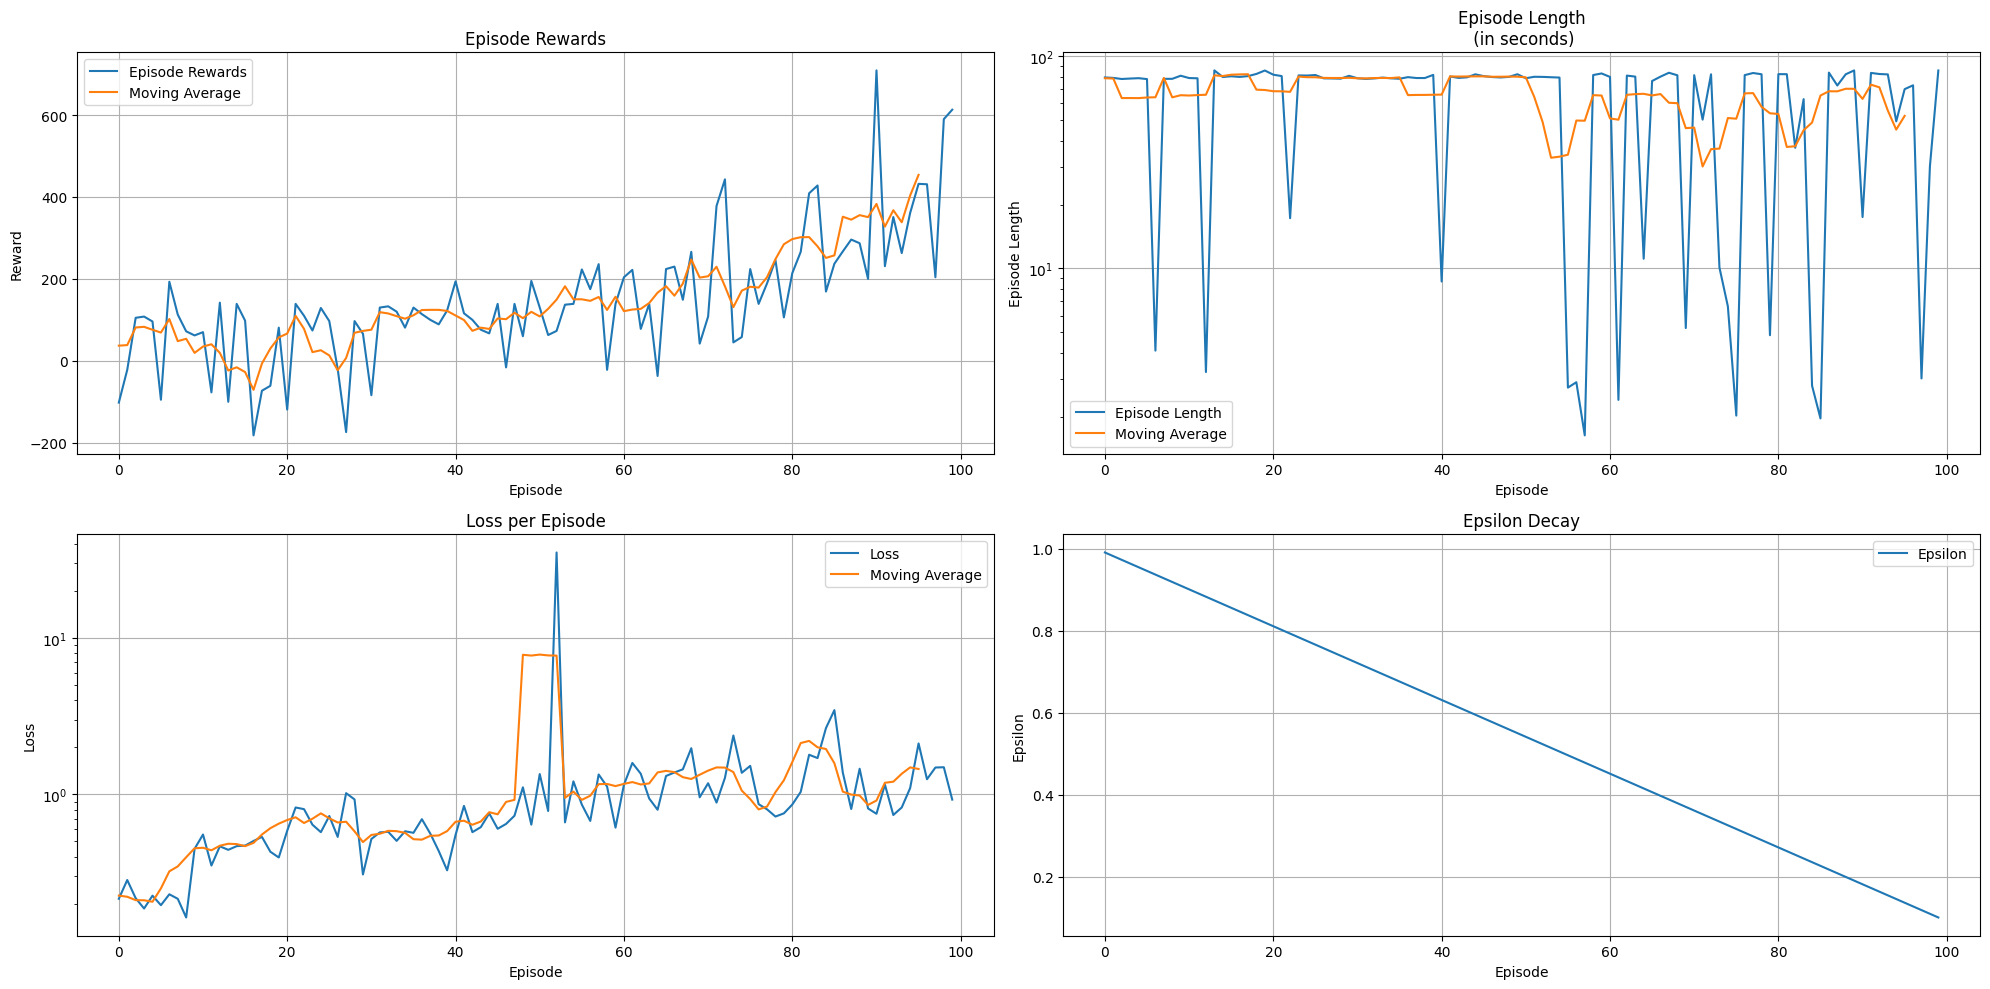

In [7]:
epsilon = EPSILON_START

episode_rewards = list()
episode_durations = list()
losses = list()
epsilon_history = list()

with tempfile.TemporaryDirectory() as checkpoint_dir:
    for episode in tqdm(range(1, N_EPISODES + 1), total=N_EPISODES, desc="Training"):
        frame_stack = collections.deque(maxlen=N_STACKD_FRAMES)
        start = time.time()
        state = env.reset()
        state = preprocess_state(
            state, frame_stack=frame_stack, stack_size=N_STACKD_FRAMES
        ).to(device)

        done = False
        total_reward = 0
        while not done:
            if np.random.rand() <= epsilon:
                action = np.random.randint(env.action_space.n)
            else:
                action = policy_net(state).argmax().item()

            next_state, reward, done, info = env.step(action)
            done = done or info["flag_get"]
            next_state = preprocess_state(
                next_state, frame_stack=frame_stack, stack_size=N_STACKD_FRAMES
            ).to(device)

            total_reward += reward

            exp = Experience(state, action, reward, done, next_state)
            replay_buffer.push(exp)

            state = next_state

            if replay_buffer.size > BATCH_SIZE:
                (
                    sample_states,
                    sample_actions,
                    sample_rewards,
                    sample_dones,
                    sample_next_states,
                ) = replay_buffer.sample(BATCH_SIZE)

                sample_states = torch.cat(sample_states)
                sample_actions = torch.LongTensor(sample_actions).to(device)
                sample_rewards = torch.FloatTensor(sample_rewards).to(device)
                sample_next_states = torch.cat(sample_next_states)
                sample_dones = torch.FloatTensor(sample_dones).to(device)

                q_curr_state = (
                    policy_net(sample_states)
                    .gather(1, sample_actions.unsqueeze(-1))
                    .squeeze(-1)
                )
                with torch.no_grad():
                    next_actions = policy_net(sample_next_states).argmax(
                        dim=1, keepdim=True
                    )
                    q_next_state = target_net(sample_next_states).gather(
                        1, next_actions
                    )
                expected_q = sample_rewards + GAMMA * q_next_state * (1 - sample_dones)

                loss = nn.MSELoss()(q_curr_state, expected_q)
                optimizer.zero_grad()
                loss.backward()
                nn.utils.clip_grad_norm_(policy_net.parameters(), 1)
                optimizer.step()

            if episode % TARGET_UPDATE == 0:
                target_net.load_state_dict(policy_net.state_dict())

            # update epsilion
        # uncomment the following line to use exponential decay
        # epsilon = max(EPSILON_END, epsilon * EPSILON_DECAY)
        # uncomment the following line to use linear decay
        epsilon = max(EPSILON_END, epsilon - EPSILON_DECAY)

        # save metrics
        episode_rewards.append(total_reward)
        episode_durations.append(time.time() - start)
        losses.append(loss.item())
        epsilon_history.append(epsilon)

        if episode % 10 == 0:
            create_plots(
                episode_rewards=episode_rewards,
                episode_lengths=episode_durations,
                episode_losses=losses,
                episode_epsilons=epsilon_history,
                save_fig=True,
                save_path=os.path.join("images_ddqn", f"results_{episode}"),
            )

        if episode % 10 == 0:
            checkpoint_path = os.path.join(checkpoint_dir, f"checkpoint_{episode}.pth")
            torch.save(
                {
                    "episode": episode,
                    "model_state_dict": policy_net.state_dict(),
                    "optimizer_state_dict": optimizer.state_dict(),
                    "loss": loss,
                    "epsilon": epsilon,
                },
                checkpoint_path,
            )

env.close()
torch.save(policy_net.state_dict(), "ddqn.pth")

### Evaluate Agent


In [4]:
eval_env = gym_super_mario_bros.make("SuperMarioBros-v0")
eval_env = JoypadSpace(eval_env, COMPLEX_MOVEMENT)
eval_env = gym.wrappers.Monitor(
    eval_env, "videos_ddqn", video_callable=lambda episode_id: True, force=True
)

# uncomment the following lines to load the model from saved checkpoint
agent = DQN(INPUT_SHAPE, eval_env.action_space.n).to(device)
agent.load_state_dict(torch.load("ddqn.pth"))
agent.eval()

DQN(
  (conv): Sequential(
    (0): Conv2d(4, 32, kernel_size=(8, 8), stride=(4, 4))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2))
    (3): ReLU()
    (4): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2))
    (5): ReLU()
  )
  (fc): Sequential(
    (0): Linear(in_features=1024, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=12, bias=True)
  )
)

In [5]:
eval_episode_rewards = list()
eval_episode_durations = list()

for episode in tqdm(range(1, 10), total=10, desc="Evaluation"):
    frame_stack = collections.deque(maxlen=N_STACKD_FRAMES)
    start = time.time()
    state = eval_env.reset()
    state = preprocess_state(
        state, frame_stack=frame_stack, stack_size=N_STACKD_FRAMES
    ).to(device)

    done = False
    total_reward = 0
    while not done:
        action = agent(state).argmax().item()
        next_state, reward, done, info = eval_env.step(action)
        done = done or info["flag_get"]

        next_state = preprocess_state(
            next_state, frame_stack=frame_stack, stack_size=N_STACKD_FRAMES
        ).to(device)

        total_reward += reward
        state = next_state

    eval_episode_rewards.append(total_reward)
    eval_episode_durations.append(time.time() - start)

eval_env.close()

Evaluation:  90%|█████████ | 9/10 [11:20<01:15, 75.66s/it]


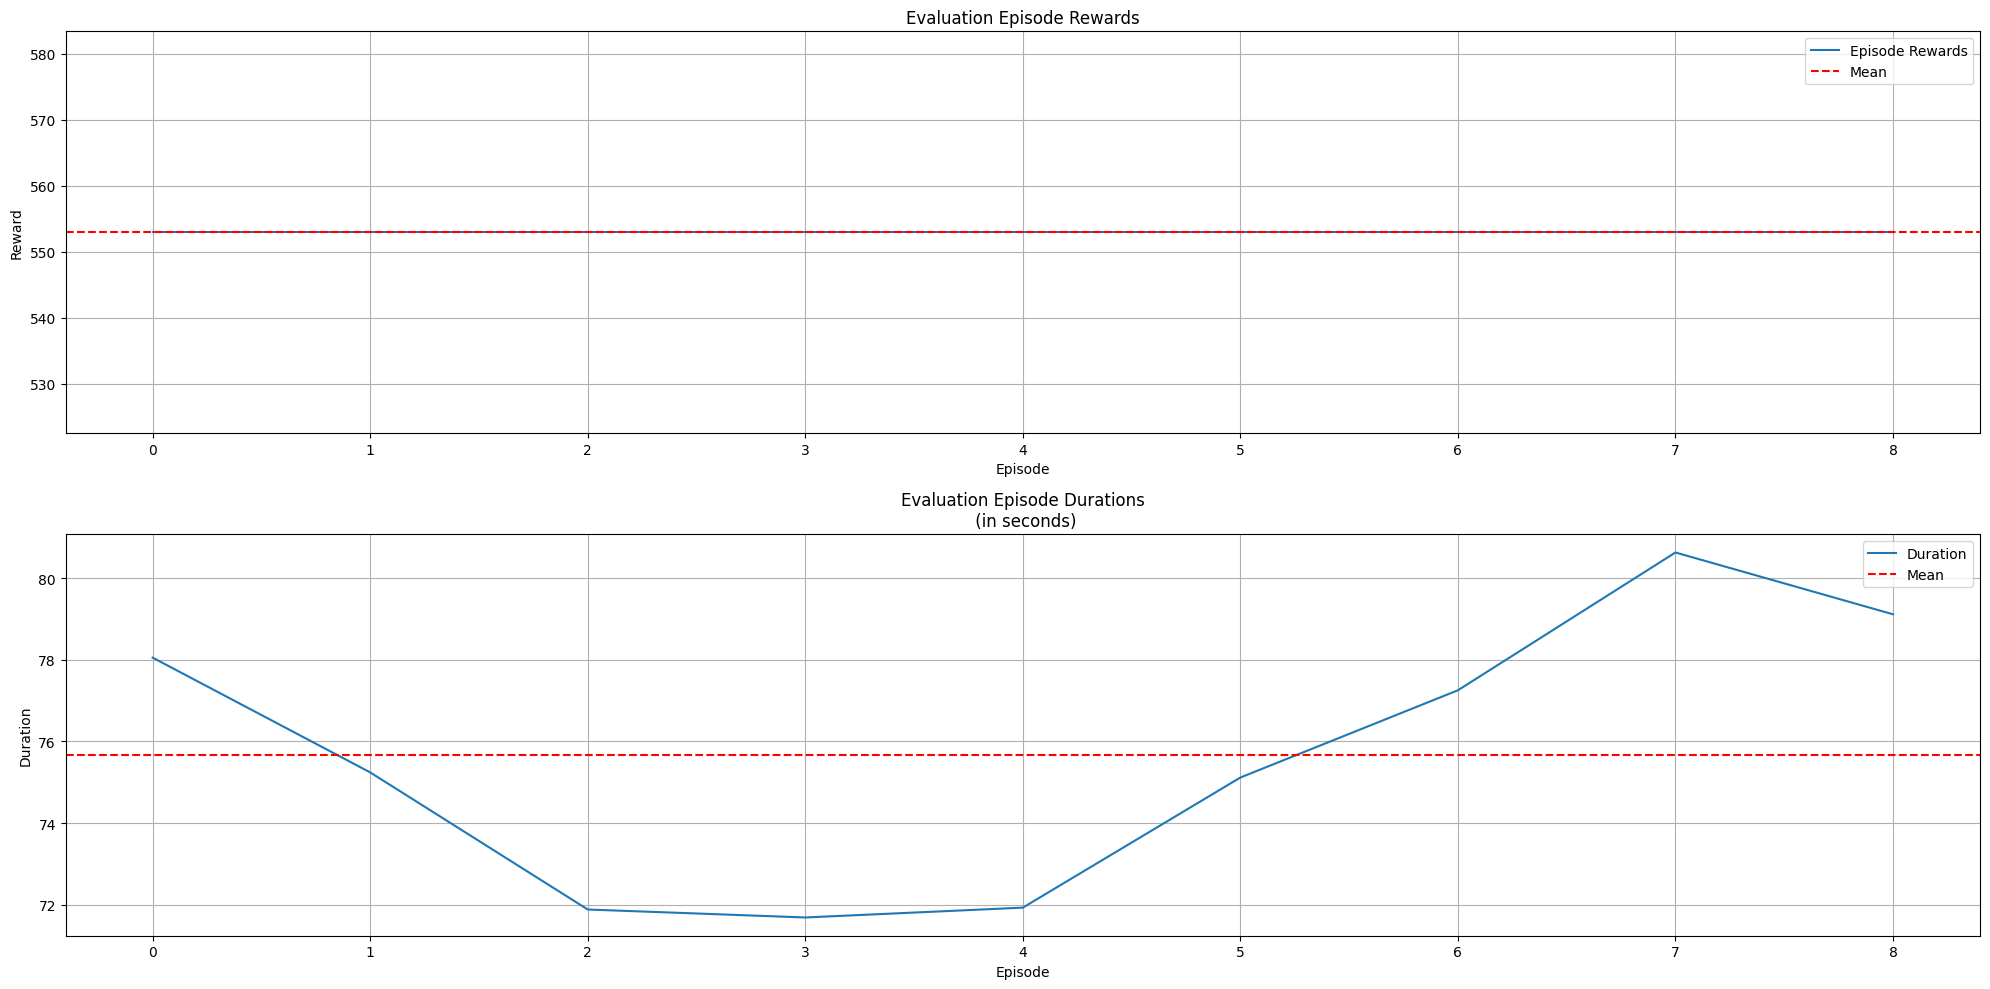

In [6]:
fig, axes = plt.subplots(figsize=(20, 10), nrows=2, ncols=1)
axes = axes.flatten()
axes[0].plot(
    np.arange(len(eval_episode_rewards)),
    eval_episode_rewards,
    label="Episode Rewards",
)
axes[0].axhline(np.mean(eval_episode_rewards), color="r", linestyle="--", label="Mean")
axes[0].set_xlabel("Episode")
axes[0].set_ylabel("Reward")
axes[0].set_title("Evaluation Episode Rewards")
axes[0].legend()
axes[0].grid(True)

axes[1].plot(
    np.arange(len(eval_episode_durations)), eval_episode_durations, label="Duration"
)
axes[1].axhline(
    np.mean(eval_episode_durations), color="r", linestyle="--", label="Mean"
)
axes[1].set_xlabel("Episode")
axes[1].set_ylabel("Duration")
axes[1].set_title("Evaluation Episode Durations\n (in seconds)")
axes[1].legend()
axes[1].grid(True)

fig.tight_layout()